# AB тест финальное задание

Задача - провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

#### Оглавление: 
<a class="anchor" id="step_0"></a>  

* [1. Техническое задание.](#step_1)
* [2. Загрузка файла и изучение общей информации.](#step_2)
* [3. Подготовка данных](#step_3)
* [4. Изучение данных](#step_4) 
* [5. Результаты эксперемента и проверка гипотез](#step_5)
* [6. Выводы](#step_6)

In [1]:
# Библиотеки для обработки данных
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st



# Настройки отображения данных
pd.set_option('max_columns', None)
pd.options.display.float_format = '{:.3f}'.format
gbs = "\033[92m" # переменная для цвета в коде начало
gbe = "\033[0m"  # переменная для цвета в коде конец

# Библиотеки для графиков
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta


from statsmodels.stats.proportion import proportions_ztest
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(16,5) # Зададим размер графиков по умолчанию

import warnings # отключим предупреждения анаконды
warnings.filterwarnings('ignore')

## 1. Техническое задание
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>

### Техническое задание
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## 2. Загрузка файла и изучение общей информации.
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>

Загрузим предложенные файлы. Выведем первые три строчки каждого, проверим данные каких типов содержатся в файлах. Проверим на дубликаты и пропуски

In [2]:
try:
    marketing_events = pd.read_csv('/Users/victor/Documents/GitHub/raw_csv/ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    
try:
    new_users = pd.read_csv('/Users/victor/Documents/GitHub/raw_csv/final_ab_new_users.csv')
except:
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    
try:
    events = pd.read_csv('/Users/victor/Documents/GitHub/raw_csv/final_ab_events.csv')
except:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    
try:
    participants = pd.read_csv('/Users/victor/Documents/GitHub/raw_csv/final_ab_participants.csv')
except:
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
# Универсальная функция если понадобится получить имя датафрейма или серии
def get_name(obj):
    name =[x for x in globals() if globals()[x] is obj][0]
    return name

In [4]:
df_list = [marketing_events, new_users, events, participants]

In [5]:
for df in df_list:
    print('-'*10, get_name(df), '-'*10)
    display(df.head(3))
    display(df.info())

---------- marketing_events ----------


name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

---------- new_users ----------


user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

---------- events ----------


user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase   99.990
1  7B6452F081F49504  2020-12-07 09:22:53   purchase    9.990
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase    4.990

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

---------- participants ----------


user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

In [6]:
for df in df_list:
    duplicates = df.duplicated().sum()
    print(get_name(df), 'выявлено дубликатов', gbs,duplicates,gbe)

marketing_events выявлено дубликатов  0 
new_users выявлено дубликатов  0 
events выявлено дубликатов  0 
participants выявлено дубликатов  0 


Данные представлены в строковом формате. Так как мы будем много работать со временем, эти данные имеет смысл перевести в `datetime`

In [7]:
for df in df_list:
    for col in df.columns:
        if 'date' in col or 'start' in col or 'dt' in col:
            df[col] = pd.to_datetime(df[col])

In [8]:
for df in df_list:
    print('-'*10, get_name(df), '-'*10)
    display(df.head(3))
    display(df.info())

---------- marketing_events ----------


name                   regions   start_dt  \
0      Christmas&New Year Promo             EU, N.America 2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2        St. Patric's Day Promo             EU, N.America 2020-03-17   

   finish_dt  
0 2021-01-03  
1 2020-02-16  
2 2020-03-19

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

---------- new_users ----------


user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

---------- events ----------


user_id            event_dt event_name  details
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase   99.990
1  7B6452F081F49504 2020-12-07 09:22:53   purchase    9.990
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase    4.990

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

---------- participants ----------


user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Выводы:
- пропусков нет;
- дубликаты есть только в столбце`details` таблицы __events__, (ими займемся позже)а так нет;
- даты приведены к `datetime`.

## 3. Подготовка данных.
[к оглавлению](#step_0)
<a class="anchor" id="step_3"></a>

Заведем переменные с ключевыми датами, после чего проверим совпадают ли маркетинговые активности в период теста с 2020-12-07 по 2021-01-04

In [9]:
start = "2020-12-07"
stop = "2020-12-21"
finish = "2021-01-04"

In [10]:
display(marketing_events)
display(marketing_events.query('start_dt >= @start & finish_dt <= @finish'))

name                   regions   start_dt  \
0           Christmas&New Year Promo             EU, N.America 2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2             St. Patric's Day Promo             EU, N.America 2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4                  4th of July Promo                 N.America 2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
6             Chinese New Year Promo                      APAC 2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC 2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS 2020-05-09   
10         CIS New Year Gift Lottery                       CIS 2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC 2020-06-25   
12           Single's Day Gift Promo                      APAC 2020-11-11   
13             Chinese Moon Festival                      APAC 2020-10-01   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
5  2020-12-01  
6  2020-02-07  
7  2020-05-03  
8  2020-03-10  
9  2020-05-11  
10 2021-01-07  
11 2020-07-01  
12 2020-11-12  
13 2020-10-07

name        regions   start_dt  finish_dt
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03

Похоже что в период теста проходит праздник Рождества в Европе. Учтем этот факт. Выделим его в переменную

In [11]:
сhristmas_start = marketing_events.loc[0]['start_dt']
сhristmas_start
print(f'Запомним дату начала Рождества {gbs}{сhristmas_start}{gbe}')

Запомним дату начала Рождества 2020-12-25 00:00:00


Отбираем только новых пользователей в нужные периоды.

In [12]:
new_users_actual = new_users.query('first_date >= @start & first_date <= @finish')
display(new_users_actual.head(3))
new_users_actual.shape[0]

user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC

61733

Определяем долю новых пользователей из Европы

In [13]:
participants.head()
print(f'Всего участников {gbs}{participants.user_id.nunique()}{gbe}')

Всего участников 16666


In [14]:
eu_participants = pd.merge(
    participants, new_users, how='left').\
query('region == "EU" & ab_test == "recommender_system_test"').user_id.nunique()
print(f'Участники теста из Европы {gbs}{eu_participants}{gbe}')

Участники теста из Европы 6351


In [15]:
eu_users = new_users.query('region == "EU"').user_id.nunique()
eu_participants / eu_users
print(f'Доля участников теста из Европы {gbs}{(eu_participants / eu_users):.2%}{gbe}')

Доля участников теста из Европы 13.73%


Это ниже уровня, который закладывался в техническом задании. Проведем тест, чтобы проверить действительно ли это статистически значимое различие:

>- __H0__: для пользователя из региона __EU__ вероятность попасть в тест составляет 15%;
>- __H1__: для пользователя из региона __EU__ вероятность попасть в тест отличается от 15%.
>- Уровень значимости установим 0.05 и откорректируем методом Бонферрони т.к. мы проводим в этой части два теста - текущий и тест на распределение пользователей по группам.

In [16]:
alpha = .05
alpha = alpha / 2
pvalue = proportions_ztest(eu_participants, eu_users, prop_var = False, value= 0.15)[1]
print(f'p-value {pvalue:.3f}')
if pvalue < alpha: 
    print('Нулевая гипотеза отвергается: для пользователя из региона EU вероятность попасть в тест отличается от 15%.')
else:
    print('Нулевая гипотеза не отвергается: для пользователя из региона EU вероятность попасть в тест 15%.')

p-value 0.000
Нулевая гипотеза отвергается: для пользователя из региона EU вероятность попасть в тест отличается от 15%.


Странно. но этот факт отбрасывает на наш тест легкую тень

Отберем пользователей не участвующих в конкурирующих тестах одновременно с нашим

In [17]:
one_test = participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test == 1').index
display(one_test[:5])
print(f'Участники подходяшие под критерий - \n\
не участвуют в конкурирующих тестах {gbs}{len(one_test)}{gbe} потери {gbs}{1-(len(one_test)/participants.user_id.nunique()):.2%}{gbe}')

Index(['0002CE61FF2C4011', '000ABE35EE11412F', '0010A1C096941592',
       '001C05E87D336C59', '001E72F50D1C48FA'],
      dtype='object', name='user_id')

Участники подходяшие под критерий - 
не участвуют в конкурирующих тестах 15064 потери 9.61%


In [18]:
one_test_participants = participants.query('user_id in@one_test & ab_test == "recommender_system_test"')
print(f"Участники подходяшие под критерий - \n\
не участвуют в конкурирующих тестах и попадают в одинаковые группы - \
{gbs}{len(one_test_participants.groupby('user_id').agg({'group':'nunique'}).query('group !=1').index)}{gbe}")


Участники подходяшие под критерий - 
не участвуют в конкурирующих тестах и попадают в одинаковые группы - 0


In [19]:
one_test_participants = participants.query('user_id in@one_test & ab_test == "recommender_system_test"')
groups = one_test_participants.groupby('group').agg({'user_id':'nunique'})


display(one_test_participants.groupby('group').agg({'user_id':'nunique'}))
print(f'Участники подходяшие под критерий - \n\
уствуют только в нашем тесте и не попадают в одинаковые группы {gbs}{one_test_participants.shape[0]}{gbe}')

user_id
group         
A         2903
B         2196

Участники подходяшие под критерий - 
уствуют только в нашем тесте и не попадают в одинаковые группы 5099


In [20]:
print(f"По интересующему нас тесту, в группе A оказалось \
{groups.iloc[0][0]} человека, \
а в группу B вошло {groups.iloc[1][0]} человек.")

По интересующему нас тесту, в группе A оказалось 2903 человека, а в группу B вошло 2196 человек.


Проверим соотношение участников группы А к группе В. Должно быль 50/50

In [21]:
a_users = groups.iloc[0][0]
#all_participants = participants_clear.shape[0]
a_users / one_test_participants.shape[0]

0.5693273190821729

Вероятность попасть в группу А составила 57%. Проверим одновыборочным z-тестом:

>- __H0__: вероятность попасть в группу __А__ составляет 50%;
>- __H1__: вероятность попасть в группу __А__ отличается от 50%Теперь  

проверим, была ли вероятность попасть в группы одинаковой:

In [22]:
alpha = .05
alpha = alpha / 2
pvalue = proportions_ztest(a_users, one_test_participants.shape[0], value= 0.5)[1]
print(f'p-value {pvalue:.2}')

if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value 1.6e-23
Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%


Штош. досадно, но не критично

В файле с событиями пользователей ранее были обнаружены пропуски в столбце __детали__. Проверим о чем они.

In [23]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [24]:
events.query('details != details')['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [25]:
events.query('details == details')['event_name'].unique()

array(['purchase'], dtype=object)

In [26]:
events['details'].value_counts()

4.990      46362
9.990       9530
99.990      5631
499.990     1217
Name: details, dtype: int64

Похоже что __детали__ это оплата корзины, причем не просто оплата, а по 4 тарифам. Пропуски по этому столбцу в остальных событиях вполне оправданы. Оставим все как есть.

Добавим в таблицу с событиями столбцы с датой и часом. По ним удобней будет группировать данные.

In [27]:
events['event_hour'] = events['event_dt'].dt.floor('h')
events['event_day'] = events['event_dt'].dt.floor('D')
events.head()

user_id            event_dt event_name  details  \
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase   99.990   
1  7B6452F081F49504 2020-12-07 09:22:53   purchase    9.990   
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase    4.990   
3  96F27A054B191457 2020-12-07 04:02:40   purchase    4.990   
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase    4.990   

           event_hour  event_day  
0 2020-12-07 20:00:00 2020-12-07  
1 2020-12-07 09:00:00 2020-12-07  
2 2020-12-07 12:00:00 2020-12-07  
3 2020-12-07 04:00:00 2020-12-07  
4 2020-12-07 10:00:00 2020-12-07

Отберем события отмеченные в период проведения теста

In [28]:
events_new = events.query('event_day >= @start & event_day <= @finish')
events_new.head()

user_id            event_dt event_name  details  \
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase   99.990   
1  7B6452F081F49504 2020-12-07 09:22:53   purchase    9.990   
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase    4.990   
3  96F27A054B191457 2020-12-07 04:02:40   purchase    4.990   
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase    4.990   

           event_hour  event_day  
0 2020-12-07 20:00:00 2020-12-07  
1 2020-12-07 09:00:00 2020-12-07  
2 2020-12-07 12:00:00 2020-12-07  
3 2020-12-07 04:00:00 2020-12-07  
4 2020-12-07 10:00:00 2020-12-07

In [29]:
first_date = events_new['event_dt'].describe()['first']
last_date = events_new['event_dt'].describe()['last']
print(f'Начало теста: {gbs}{first_date}{gbe} \nКонец теста: {gbs}{last_date}{gbe} \nитоговая длительность {gbs}{last_date - first_date}{gbe}')

Начало теста: 2020-12-07 00:00:33 
Конец теста: 2020-12-30 23:36:33 
итоговая длительность 23 days 23:36:00


Соединим все ранее очищенные таблицы в одну рабочую, там же добавим столбец с тарифом покупки.

In [30]:
work_df = (one_test_participants
                      .merge(new_users_actual, on='user_id', how='left')
                      .merge(events_new, on='user_id', how='left')
                      .reset_index(drop=True)
                 )
work_df['purchase_type'] = work_df.query('event_name == "purchase"')['details'].apply(lambda x: str(x)+' usd')
work_df.head(3)

user_id group                  ab_test first_date region device  \
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
1  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
2  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   

             event_dt    event_name  details          event_hour  event_day  \
0 2020-12-07 14:43:27      purchase   99.990 2020-12-07 14:00:00 2020-12-07   
1 2020-12-25 00:04:56      purchase    4.990 2020-12-25 00:00:00 2020-12-25   
2 2020-12-07 14:43:29  product_cart      NaN 2020-12-07 14:00:00 2020-12-07   

  purchase_type  
0     99.99 usd  
1      4.99 usd  
2           NaN

In [31]:
work_df = work_df.query('event_dt >= first_date').reset_index(drop=True)
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18804 entries, 0 to 18803
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        18804 non-null  object        
 1   group          18804 non-null  object        
 2   ab_test        18804 non-null  object        
 3   first_date     18804 non-null  datetime64[ns]
 4   region         18804 non-null  object        
 5   device         18804 non-null  object        
 6   event_dt       18804 non-null  datetime64[ns]
 7   event_name     18804 non-null  object        
 8   details        2483 non-null   float64       
 9   event_hour     18804 non-null  datetime64[ns]
 10  event_day      18804 non-null  datetime64[ns]
 11  purchase_type  2483 non-null   object        
dtypes: datetime64[ns](4), float64(1), object(7)
memory usage: 1.7+ MB


In [32]:
print(f"Объединение прошло без накладок. Уникальных пользователей {gbs}{work_df['user_id'].nunique()}{gbe}")
print(f"Всего строк {gbs}{work_df['user_id'].count()}{gbe}")

Объединение прошло без накладок. Уникальных пользователей 2788
Всего строк 18804


## 4. Изучение данных.
[к оглавлению](#step_0)
<a class="anchor" id="step_4"></a>

Выведем таблицу с агренированным данными по шагам воронки и собственно воронку. Проверим как участники двух групп перемещались по шагам.

In [33]:
def metric_tab(df):
    res = df.groupby(['event_name', 'group']).agg({'user_id':'nunique'}).unstack().reset_index()
    res.columns = ['event_name','A', 'B']
    res.index = [1, 3, 2, 4]
    res.sort_index(inplace=True)
    res['A_conv'] = res['A'].shift(fill_value=res.iloc[0][1])
    res['B_conv'] = res['B'].shift(fill_value=res.iloc[0][2])
    res['A_conv'] = res['A'] / res['A_conv']
    res['B_conv'] = res['B'] / res['B_conv']
    res['conv_dif'] = res['B_conv'] / res['A_conv'] - 1
    return res

In [34]:
metricas = metric_tab(work_df)
metricas

event_name     A    B  A_conv  B_conv  conv_dif
1         login  2082  706   1.000   1.000     0.000
2  product_page  1360  397   0.653   0.562    -0.139
3  product_cart   631  195   0.464   0.491     0.059
4      purchase   652  198   1.033   1.015    -0.017

In [35]:
fig = go.Figure(go.Funnel(
    name='группа A',
    y = metricas['event_name'],
    x = metricas['A'],
    textinfo = 'value+percent initial+percent previous'))

fig.add_trace(go.Funnel(
    name='группа B',
    y = metricas['event_name'],
    x = metricas['B'],
    textinfo = 'value+percent initial+percent previous'))

fig.update_layout(template='seaborn',
                  title='<b>Воронка событий по тестовым группам</b>')

fig.show()

Воронка показывает на последнем шаге - оплаты корзины __103%__ от предыдущего шага. Такое бывает если на сайте присутствует возможность быстрой покупки. А так, на шаге от логина до просмотра товаров ушло __35%__, на шаге от просмотра товаров до корзины/оплаты, потери составили еще __35%__. Итого __70%__ потерь клиентов. По изменениям коэффициентов конверсии по шагам так же есть отклонения.

Проверим почасовую и дневную активность участников двух групп. Для этого создадим функцию выводящую графики активности

In [36]:
def activity_plot(df, title=None):
    hour_activity = df.groupby(['event_hour','group']).agg({'event_dt':'count'}).reset_index()
    day_activity = df.groupby(['event_day','group']).agg({'event_dt':'count'}).reset_index('group')
    day_activity.index = day_activity.index.strftime('%Y-%m-%d')
    fig, axs = plt.subplots(2, 1, figsize=(20, 12))
    sns.lineplot(y='event_dt',
                 x='event_hour',
                 hue='group', 
                 data=hour_activity, ax=axs[0]).set(title=f'Почасовая активность пользователенй групп А и В {title}', 
                                                    ylabel='', 
                                                    xlabel='')
    sns.barplot(y='event_dt',
                x=day_activity.index, hue='group',
                data=day_activity, ax=axs[1]).set(title=f'Дневная активность пользователенй групп А и В {title}', 
                                                  ylabel='', 
                                                  xlabel='')
                                                  
    plt.xticks(rotation=45)
    plt.show()
    print(metric_tab(df))

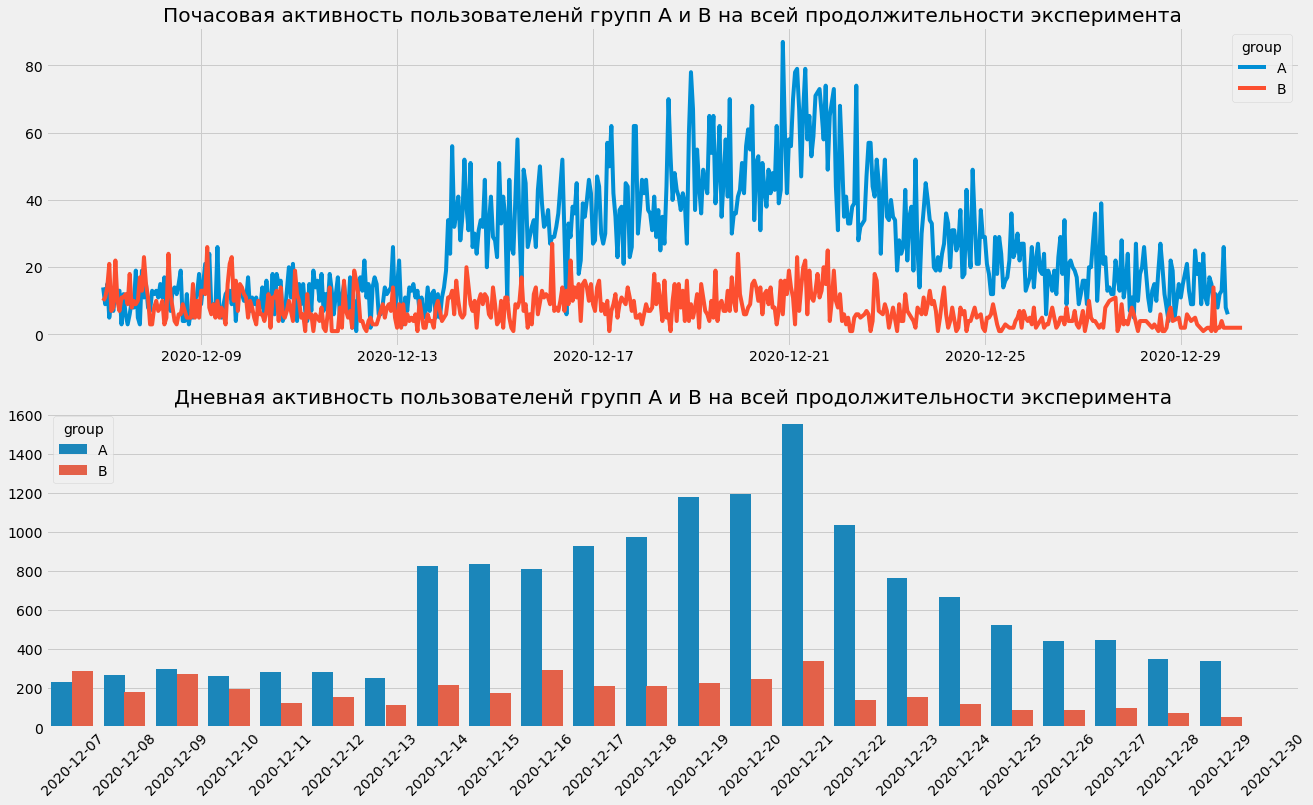

     event_name     A    B  A_conv  B_conv  conv_dif
1         login  2082  706   1.000   1.000     0.000
2  product_page  1360  397   0.653   0.562    -0.139
3  product_cart   631  195   0.464   0.491     0.059
4      purchase   652  198   1.033   1.015    -0.017


In [37]:
activity_plot(work_df, 'на всей продолжительности эксперимента')

Графики демонстрируют странный переломный момент, когда участников группы А стало заметно больше.

In [38]:
break_find = work_df.groupby(['event_day','group']).agg({'event_dt':'count'}).reset_index('group').query('group == "A"')
break_find['event_prev'] = break_find['event_dt'].shift()
break_find['grow'] = (break_find['event_dt'] / break_find['event_prev'])
break_point = break_find.query('grow == @break_find.grow.max()').index[0]
print(f'До этого дня {gbs}{break_point}{gbe} данные о пользователях в груп более не менее однородны')

До этого дня 2020-12-14 00:00:00 данные о пользователях в груп более не менее однородны


Вспомним что на период теста пришлись маркетинговые акции связанные с Рождеством. Выведем усеченные графики между датой перекоса и началом Рождества, и на всякий случай до перекоса

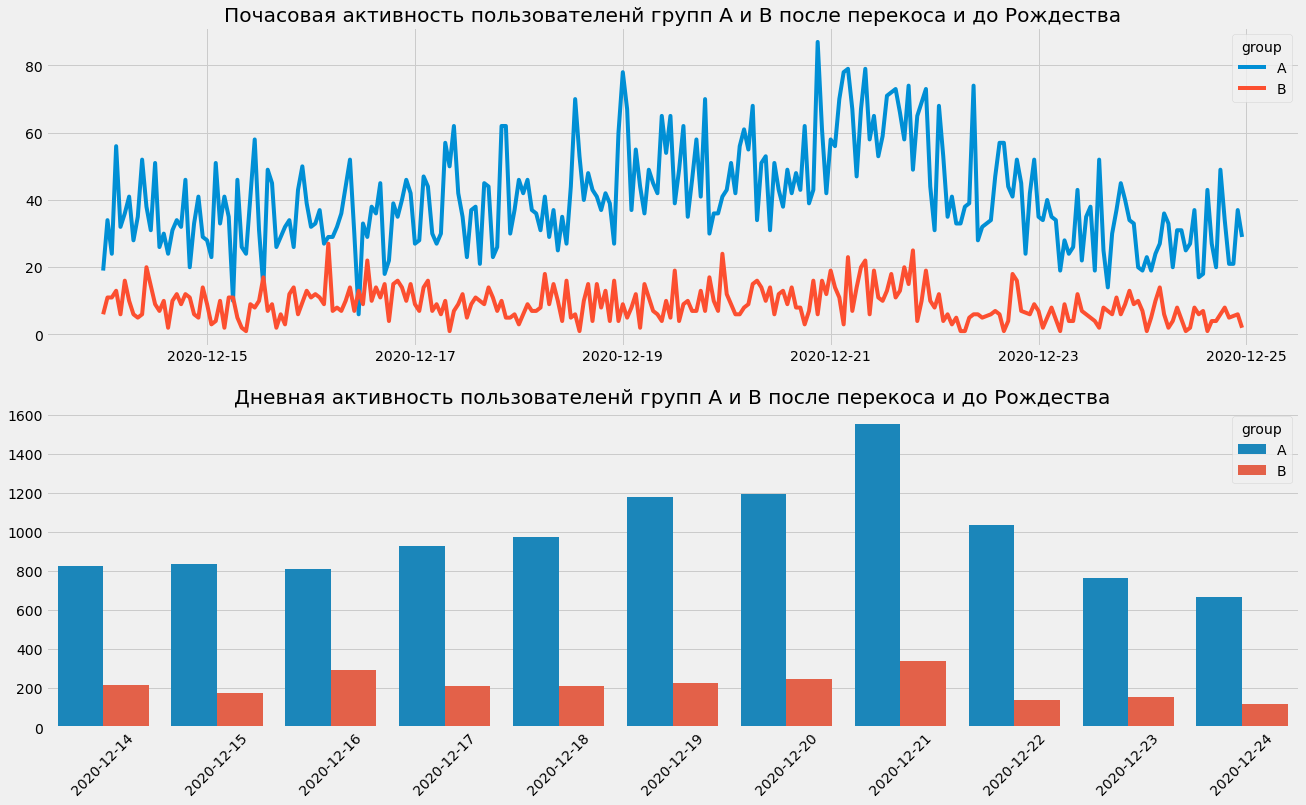

     event_name     A    B  A_conv  B_conv  conv_dif
1         login  1909  571   1.000   1.000     0.000
2  product_page  1250  318   0.655   0.557    -0.149
3  product_cart   587  165   0.470   0.519     0.105
4      purchase   594  159   1.012   0.964    -0.048


In [39]:
activity_plot(work_df.query('event_day >= @break_point & event_day < @сhristmas_start'), 'после перекоса и до Рождества')

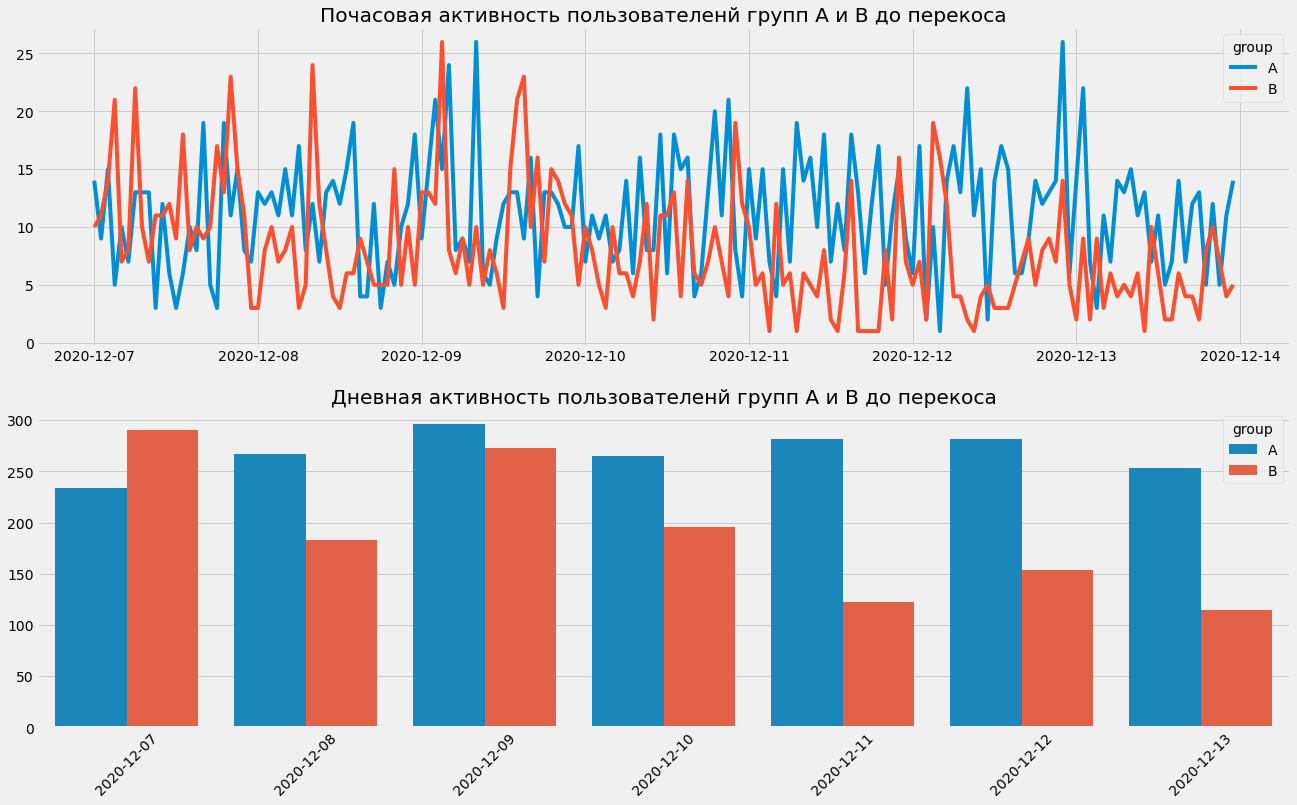

     event_name    A    B  A_conv  B_conv  conv_dif
1         login  464  323   1.000   1.000     0.000
2  product_page  282  179   0.608   0.554    -0.088
3  product_cart  116   80   0.411   0.447     0.086
4      purchase  117   87   1.009   1.087     0.078


In [40]:
activity_plot(work_df.query('event_day < @break_point'), 'до перекоса')

Оба графика показывают не самые лучшие для теста данные. Заведем три версии рабочего датафрейма:

>- от начала до Рождества
>- от перекоса до Рождества
>- от начала до перекоса

In [41]:
work_df_1 = work_df.query('event_day < @сhristmas_start')
work_df_1.head()

user_id group                  ab_test first_date region  device  \
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU      PC   
2  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU      PC   
4  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU      PC   
6  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU      PC   
8  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone   

             event_dt    event_name  details          event_hour  event_day  \
0 2020-12-07 14:43:27      purchase   99.990 2020-12-07 14:00:00 2020-12-07   
2 2020-12-07 14:43:29  product_cart      NaN 2020-12-07 14:00:00 2020-12-07   
4 2020-12-07 14:43:27  product_page      NaN 2020-12-07 14:00:00 2020-12-07   
6 2020-12-07 14:43:27         login      NaN 2020-12-07 14:00:00 2020-12-07   
8 2020-12-20 15:46:06  product_page      NaN 2020-12-20 15:00:00 2020-12-20   

  purchase_type  
0     99.99 usd  
2           NaN  
4           NaN  
6           NaN  
8           NaN

In [42]:
work_df_2 = work_df.query('event_day >= @break_point & event_day < @сhristmas_start')
work_df_2.head()

user_id group                  ab_test first_date region  device  \
8   A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone   
9   A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone   
11  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone   
12  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone   
14  4FF2998A348C484F     A  recommender_system_test 2020-12-20     EU     Mac   

              event_dt    event_name  details          event_hour  event_day  \
8  2020-12-20 15:46:06  product_page      NaN 2020-12-20 15:00:00 2020-12-20   
9  2020-12-21 00:40:59  product_page      NaN 2020-12-21 00:00:00 2020-12-21   
11 2020-12-20 15:46:02         login      NaN 2020-12-20 15:00:00 2020-12-20   
12 2020-12-21 00:40:58         login      NaN 2020-12-21 00:00:00 2020-12-21   
14 2020-12-20 19:06:22      purchase    4.990 2020-12-20 19:00:00 2020-12-20   

   purchase_type  
8            NaN  
9            NaN  
11           NaN  
12           NaN  
14      4.99 usd

In [43]:
work_df_3 = work_df.query('event_day < @break_point')
work_df_3.head()

user_id group                  ab_test first_date region device  \
0   D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
2   D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
4   D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
6   D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
36  92CB588012C10D3D     A  recommender_system_test 2020-12-09     EU     PC   

              event_dt    event_name  details          event_hour  event_day  \
0  2020-12-07 14:43:27      purchase   99.990 2020-12-07 14:00:00 2020-12-07   
2  2020-12-07 14:43:29  product_cart      NaN 2020-12-07 14:00:00 2020-12-07   
4  2020-12-07 14:43:27  product_page      NaN 2020-12-07 14:00:00 2020-12-07   
6  2020-12-07 14:43:27         login      NaN 2020-12-07 14:00:00 2020-12-07   
36 2020-12-09 16:22:45  product_page      NaN 2020-12-09 16:00:00 2020-12-09   

   purchase_type  
0      99.99 usd  
2            NaN  
4            NaN  
6            NaN  
36           NaN

Проверим активность групп А и В по другим измерениям рабочих таблиц. 

>- Какие события зафиксированы, 
>- из каких регионов участники, 
>- с каких устройств заходили

In [44]:
def dimension_compare(df, title=None):
    fig, axs = plt.subplots(3, 2, figsize=(20, 12))
    dimension = ['event_name','region','device']
    
    for i, key in enumerate(dimension):
        
        a =df.query('group == "A"').groupby(['event_hour',key]).agg({'event_dt':'count'}).reset_index()
        sns.lineplot(y='event_dt', x='event_hour', hue=key, data=a, ax = axs[i][0]).set(title='Группа А', ylabel=f'{key}', xlabel='')
        axs[i][0].tick_params(axis='x', labelrotation=45)
        
        b =df.query('group == "B"').groupby(['event_hour',key]).agg({'event_dt':'count'}).reset_index()
        sns.lineplot(y='event_dt', x='event_hour', hue=key, data=b, ax = axs[i][1]).set(title='Группа В', ylabel=f'{key}', xlabel='')
        axs[i][1].tick_params(axis='x', labelrotation=45)
        
    plt.suptitle(f'Сравнение измерений {title}', size=17)
    plt.subplots_adjust(wspace=0.1, hspace=0.8)
    plt.show()

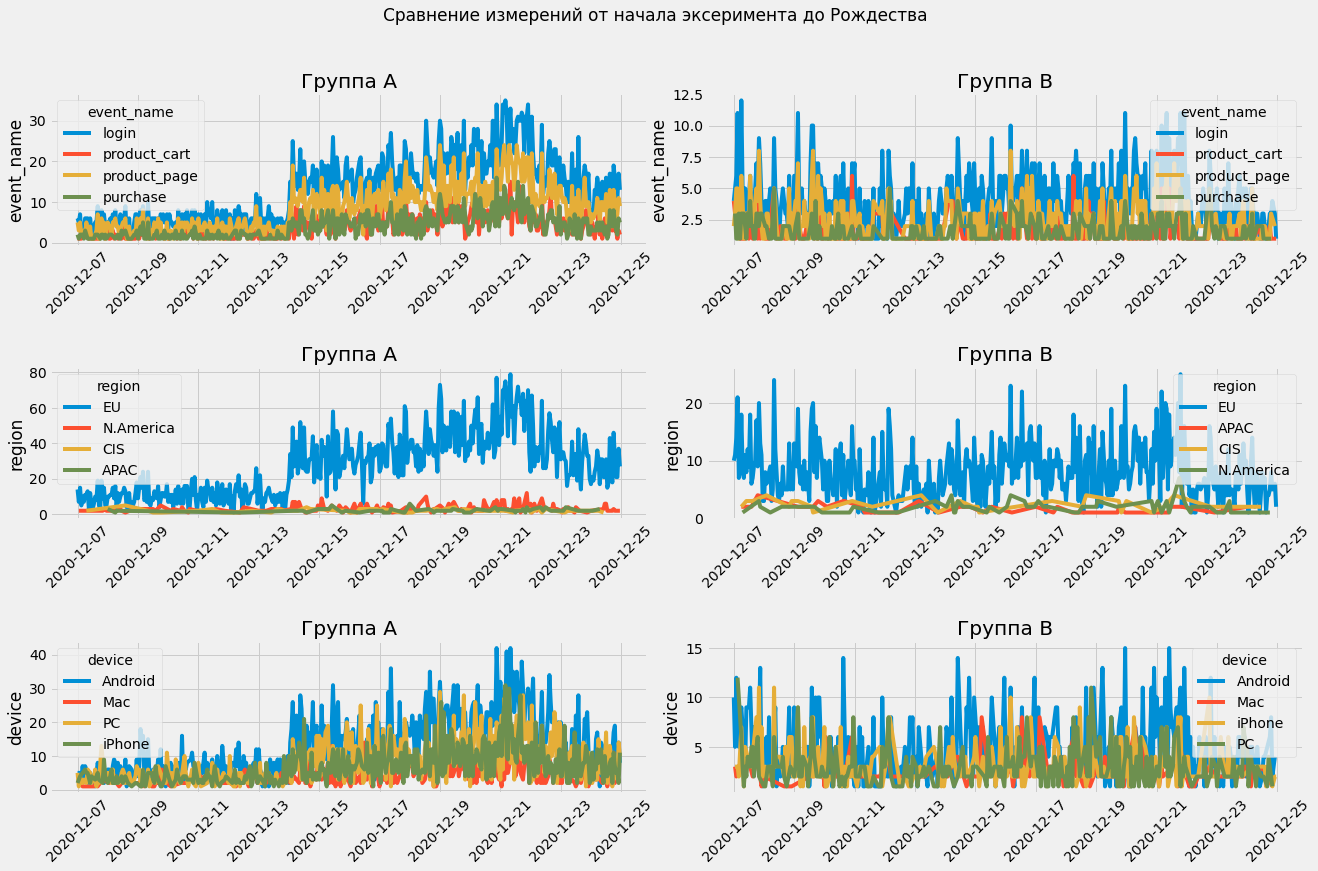

In [45]:
dimension_compare(work_df_1, 'от начала эксеримента до Рождества')

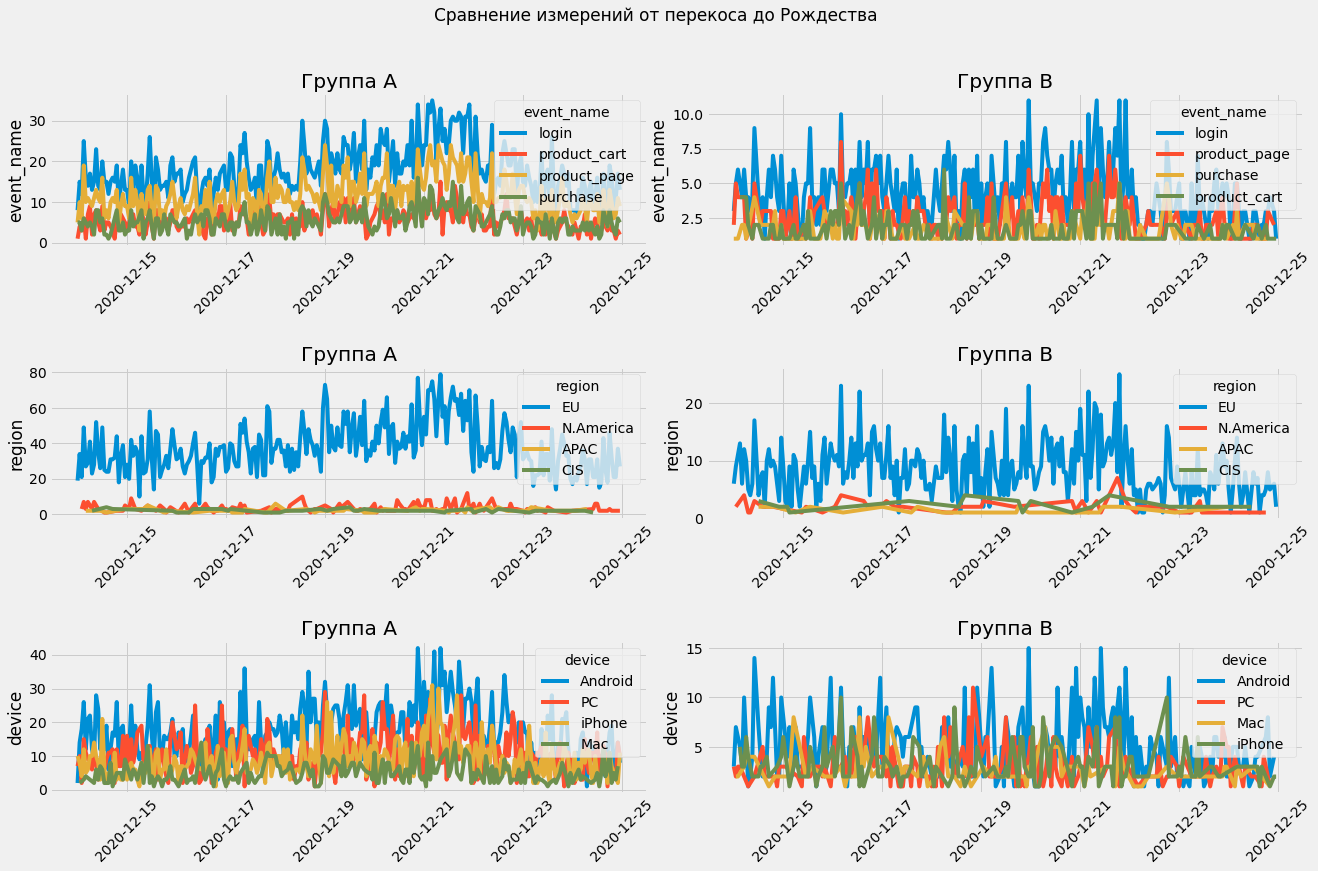

In [46]:
dimension_compare(work_df_2, 'от перекоса до Рождества')

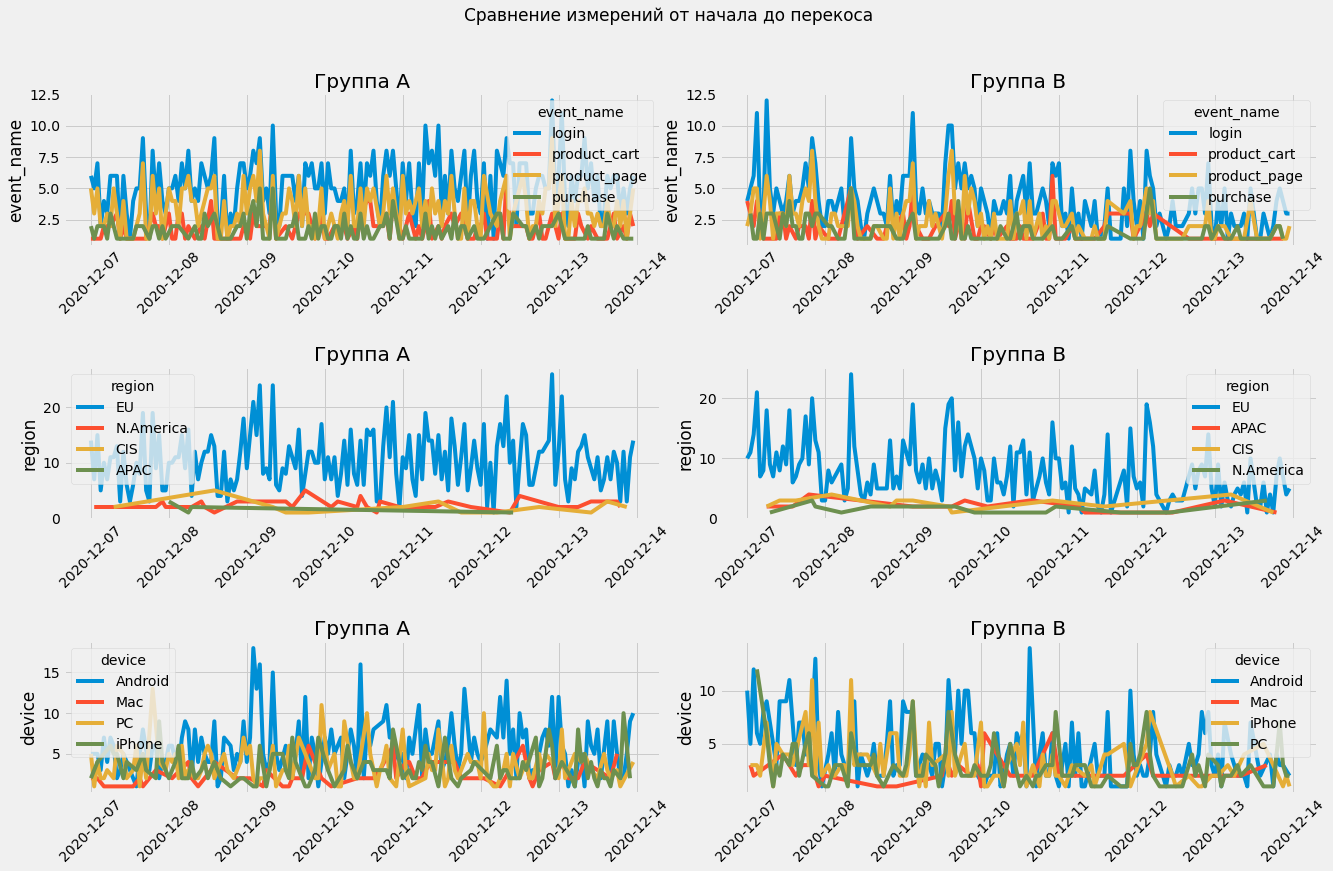

In [47]:
dimension_compare(work_df_3, 'от начала до перекоса')

По всем признакам правильнее выбрать промежуток от начала эксперимента до перекоса в качестве рабочего.

Выведем кумулятивные графики конверсий графики относительного изменения кумулятивных конверсий. Для этого создадим несколько функции. Первая будет собирать датафрейм с накопительными метриками, остальные выводить графики.

In [48]:
def cumulative_data(df, event):
    '''
    ФУНЦИЯ СОЗДАЮЩАЯ КУМУЛЯТИВНЫЕ ДАТАФРЕЙМЫ ПО ДАТАМ
    1) на вход подаем сырую рабочую таблицу
    2) внутри пошагово добавляем накопленые метриуи для каждой из групп
    3) на выходе получаем список из двух датафеймов (для конверсий и для относительного изменения конверсий)
    4) возвращаем нужный датафрейм по индексу
    '''
    df = df.query('event_name == @event')
    dates_groups = df[['event_day','group']].drop_duplicates().sort_values(by='event_day').reset_index(drop=True)

    df_agg_1 = dates_groups.apply(
    lambda x: df[np.logical_and(
        df['event_day'] <= x['event_day'], df['group'] == x['group'])].agg(
        {'event_day':'max', 
        'group':'max', 
        'user_id':'nunique', 
        'details':'sum'}), axis=1).sort_values(by=['event_day','group']) 
    df_agg_2 = dates_groups.apply(
    lambda x: df[np.logical_and(
        df['event_day'] <= x['event_day'], df['group'] == x['group'])].agg(
        {'event_day':'max', 
        'group':'max', 
        'event_name':'count'}), axis=1).sort_values(by=['event_day','group']) 
    cumul_data = pd.merge(df_agg_1, df_agg_2, on=['event_day', 'group'])
    cumul_data.columns = ['event_day', 'group', 'user_cnt', 'revenue', 'event_cnt']
    cumul_data['aov'] = cumul_data['revenue'] / cumul_data['event_cnt']
    cumul_data_horizont = cumul_data.\
    pivot_table(index= 'event_day', columns=['group'], values=['user_cnt',	'revenue', 'event_cnt']).reset_index()
    cumul_data_horizont.columns = [''.join(col).strip() for col in cumul_data_horizont.columns.values]
    cumul_data_horizont['rc_cr'] = (cumul_data_horizont['event_cntB'] / \
                                    cumul_data_horizont['user_cntB']) / \
    (cumul_data_horizont['event_cntA'] / cumul_data_horizont['user_cntA']) - 1
    cumul_data_horizont['rc_aov'] = (cumul_data_horizont['revenueB'] / \
                                     cumul_data_horizont['event_cntB']) / \
    (cumul_data_horizont['revenueA'] / cumul_data_horizont['event_cntA']) - 1
    return cumul_data, cumul_data_horizont

In [49]:
def cumu_plot(df, event, type_data=1, title=None):
    '''
    ФУНЦИЯ СОЗДАЮЩАЯ КУМУЛЯТИВНЫЕ ГРАФИКИ
    1) на вход подаем сырую рабочую таблицу, название события, тип датафрейма, название, по желанию
    2) Если тип 0 - это индекс из предыдущей фенкции, строим график кумулятивных конверсий
    3) Если тип 1 - это индекс из предыдущей фенкции, строим график относительного изменения кумулятивных конверсий
    4) Запускаем функцию в цикле
    '''
    if type_data == 0:
        tech_df = cumulative_data(df, event)[type_data]
        tech_df['conv'] = tech_df['event_cnt'] / tech_df['user_cnt']
        sns.lineplot(data=tech_df, x='event_day', y='conv', hue='group', palette='bright', ci=None, estimator='sum')
        plt.title(f'Кумулятивная конверсия в - {title}')
        plt.xticks(rotation=45)
        plt.xlabel('', size=12)
    elif type_data == 1:
        tech_df = cumulative_data(df, event)[type_data]
        sns.lineplot(data=tech_df, x='event_day', y='rc_cr', palette='bright', ci=None, estimator='mean')
        plt.axhline(y=0, color='black', linestyle='--')
        plt.axhline(y=float(tech_df.rc_cr[-1:]), color='green', linestyle='--') 
        plt.title(f'Относительное изменение конверсии\n группы А к группе В - {title}')
        plt.xticks(rotation=45)
        plt.xlabel('', size=12)


In [50]:
def cumul_purchase_plot(df):
    '''
    ФУНЦИЯ СОЗДАЮЩАЯ ГРАФИК КУМУЛЯТИВНОЙ ВЫРУЧКИ
    1) на вход подаем сырую рабочую таблицу
    2) так как выркчка только в событии purchase, дополнительных условий никаких
    3) получаем график
    '''
    tech_df = cumulative_data(df, 'purchase')[0]
    sns.lineplot(data=tech_df, x='event_day', y='revenue', hue='group', palette='bright', ci=None, estimator='sum')
    plt.title('Кумулятивная выручка по группам')
    plt.xticks(rotation=45)
    plt.xlabel('', size=12)


In [51]:
def purchase_plot(df, type_data=1, title=None):
    '''
    ФУНЦИЯ СОЗДАЮЩАЯ ГРАФИК КУМУЛЯТИВНОЙ СРЕДНЕЙ ВЫРУЧКИ
    1) на вход подаем сырую рабочую таблицу, тип датафрейма, название, по желанию
    2) Если тип 0 - это индекс из предыдущей фенкции, строим график кумулятивных средних продаж
    3) Если тип 1 - это индекс из предыдущей фенкции, строим график относительного изменения кумулятивных средних продаж
    4) получаем графики
    '''
    if type_data == 0:
        tech_df = cumulative_data(df, 'purchase')[type_data]
        sns.lineplot(data=tech_df, x='event_day', y='aov', hue='group', palette='bright', ci=None, estimator='sum')
        plt.title(f'Средняя покупка')
        plt.xticks(rotation=45)
        plt.xlabel('', size=12)
    elif type_data == 1:
        tech_df = cumulative_data(df, 'purchase')[type_data]
        sns.lineplot(data=tech_df, x='event_day', y='rc_aov', palette='bright', ci=None, estimator='mean')
        plt.axhline(y=0, color='black', linestyle='--')
        plt.axhline(y=float(tech_df.rc_aov[-1:]), color='green', linestyle='--') 
        plt.title(f'Относительное изменение средней покупки')
        plt.xticks(rotation=45)
        plt.xlabel('', size=12)

Запустим наши графики. Предварительно в цикл будем подавать словарь с техническим и русским названием события

In [52]:
events = {'product_page':'просмотр товара', 
          'product_cart':'просмотр корзины',
          'purchase':'оплата заказа'}

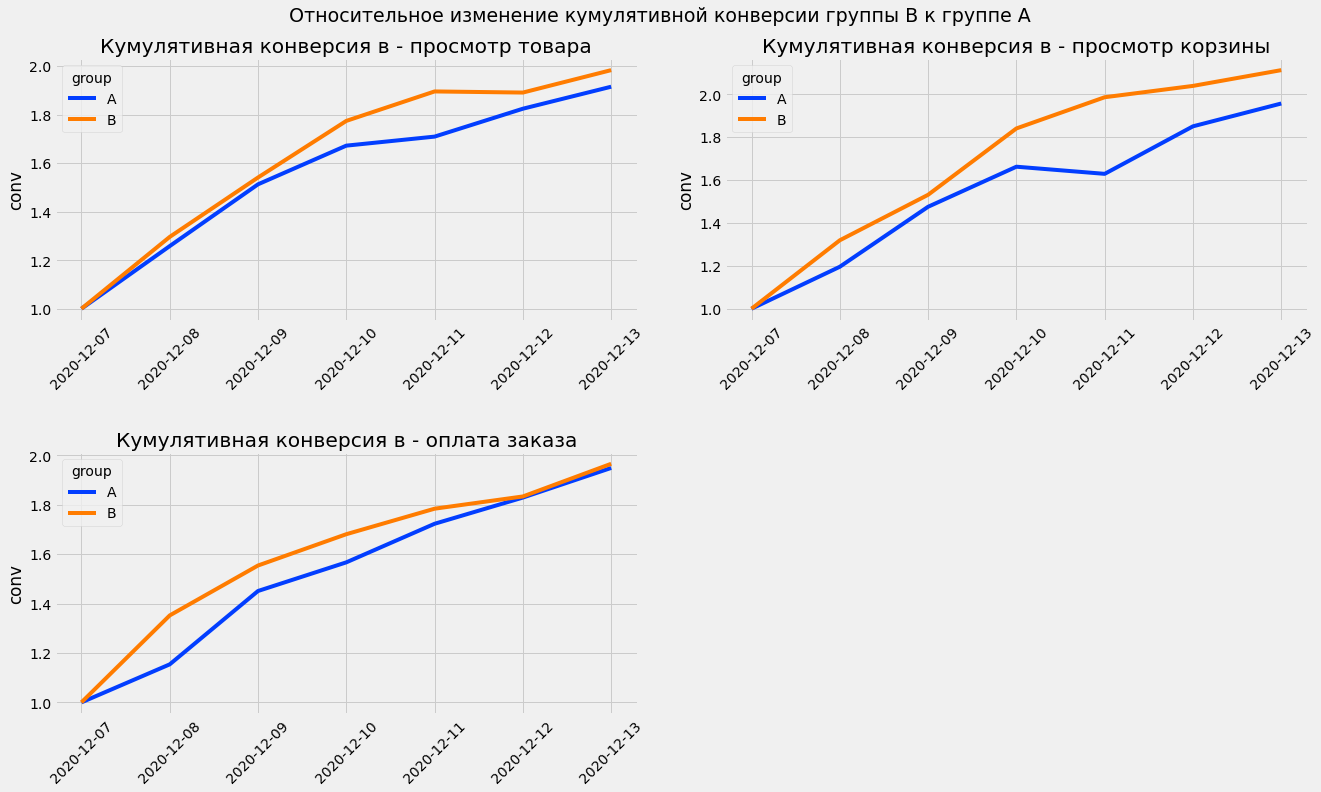

In [53]:
fig = plt.figure(figsize=(20,18))
i = 1
for key in events:
    fig.add_subplot(3, 2, i)
    cumu_plot(work_df_3, key, 0, events[key])
    i += 1
plt.suptitle('Относительное изменение кумулятивной конверсии группы B к группе A', size=19, y=0.92)
plt.subplots_adjust(wspace=0.15, hspace=0.5)
plt.show()

За первую неделю проведения теста группа В незначительно лучше группы А. Причем в группе А есть провал __11 декабря__ в просмотрах товара и корзины, и незначительный провал в покупках в самом начале теста __08 декабря__

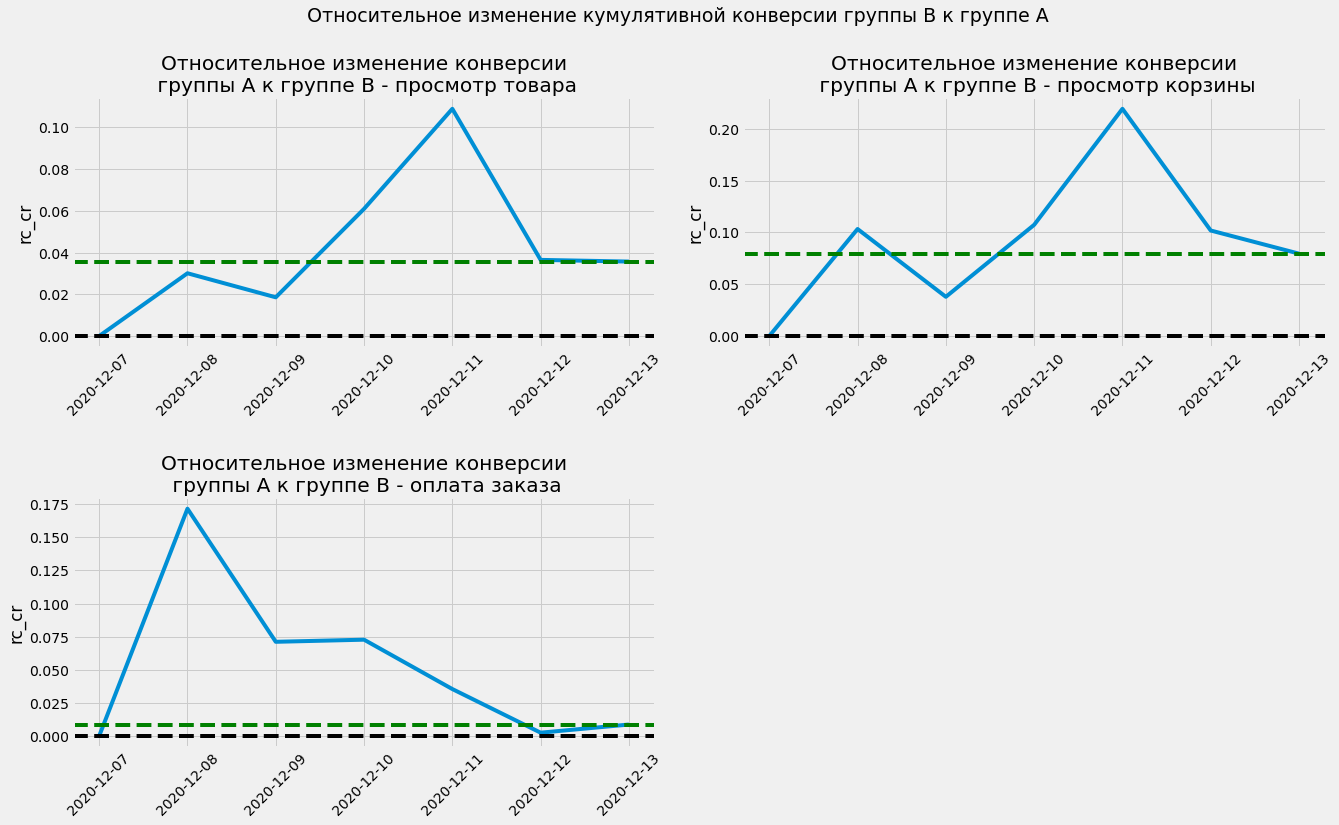

In [54]:
fig = plt.figure(figsize=(20,18))
i = 1
for key in events:
    fig.add_subplot(3, 2, i)
    cumu_plot(work_df_3, key, 1, events[key])
    i += 1
plt.suptitle('Относительное изменение кумулятивной конверсии группы B к группе A', size=19, y=0.95)
plt.subplots_adjust(wspace=0.15, hspace=0.6)
plt.show()

Относительное изменения конверсий повторяют предыдущие графики со слегка иной стороны. Все тот же провал в группе А __11 декабря__ выгибает графики просмотра товара и просмотра корзины. По оплатам тот же выгиб __8 декабря__

Присмотримся точечным распределениям количества отплат по четырем тарифам. Для этого так же создадим функцию.

In [55]:
def scatter_plot(df, title, ymin=None, ymax=None, est='count'):
    '''
    ФУНКЦИЯ ДЛЯ ВЫВОДА ГРАФИКА РЕСПРЕДЕЛЕНИЯ РАСПРЕДЕЛЕНИЯ ОПЛАТ
    На вход подаем:
    1. Сырой датафрейм и название
    2. Внутри группируем по тарифам, количество оплат
    3. Расчитываем персентили
    4. Выводим график
    '''
    fig = plt.subplots(figsize=(12,5))
    data = df.groupby(['purchase_type', 'user_id']).\
    agg({'event_dt':est}).reset_index().sort_values(by='purchase_type').reset_index(drop=True)    
    sns.scatterplot(data=data, x=data.index, hue='purchase_type', y='event_dt', alpha=0.9)
    cuts = [75, 90, 95, 99]
    percentiles = np.percentile(data['event_dt'], cuts)
    for i in range(len(percentiles)):
        plt.axhline(y=percentiles[i], color='#5F9EA0', linewidth=1.5, linestyle='--')
        plt.text(x = data.shape[0], y=percentiles[i], s=f'{cuts[i]} персентиль', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

In [56]:
def outlerz(df, percentile=95):
    '''
    ФУНКЦИЯ ДЛЯ СПИСКА УЧАСТНИКОВ ПОПАДАЮЩИХ ПОД ВЫБРОСЫ
    На вход подаем:
    1. Сырой датафрейм и название и номер персентиля (по умолчанию 95)
    2. Выводим список с id участников
    '''
    data = df.groupby(['purchase_type', 'user_id']).agg({'event_dt':'count'}).reset_index().sort_values(by='purchase_type').reset_index(drop=True)
    outler = np.percentile(data['event_dt'], percentile)
    return data.query('event_dt > @outler')['user_id']

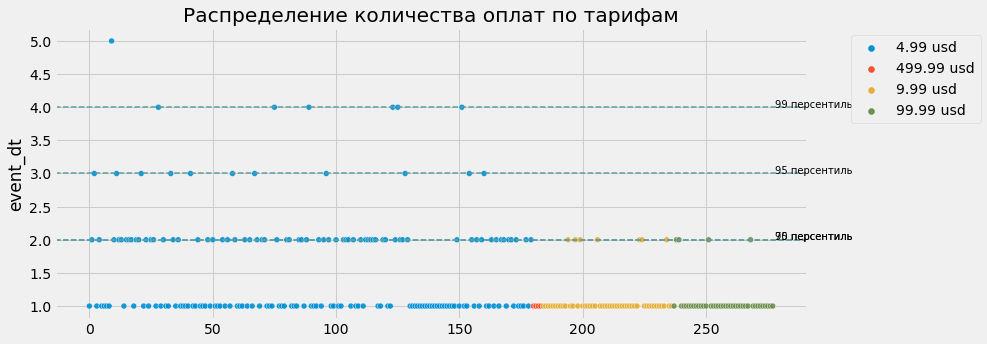

In [57]:
scatter_plot(work_df_3, 'Распределение количества оплат по тарифам')

In [58]:
print(f"Всего выбросных участников {gbs}{len(outlerz(work_df_3))}{gbe}")

Всего выбросных участников 7


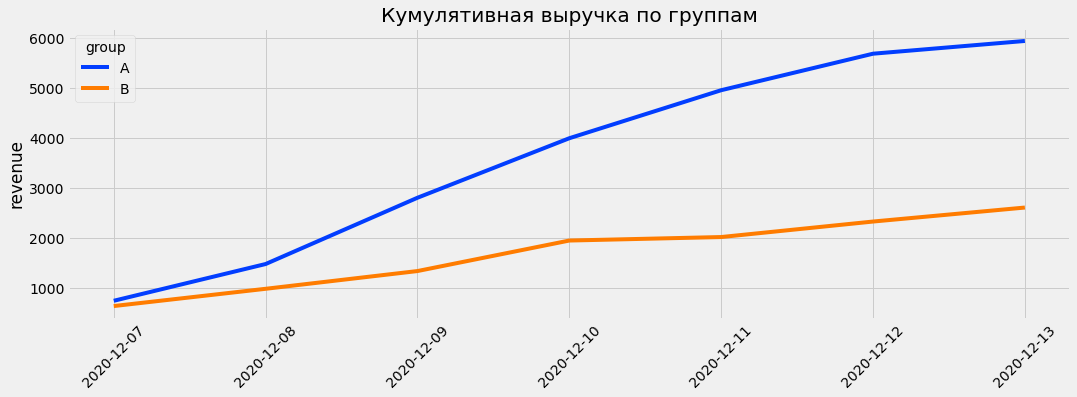

In [59]:
cumul_purchase_plot(work_df_3)

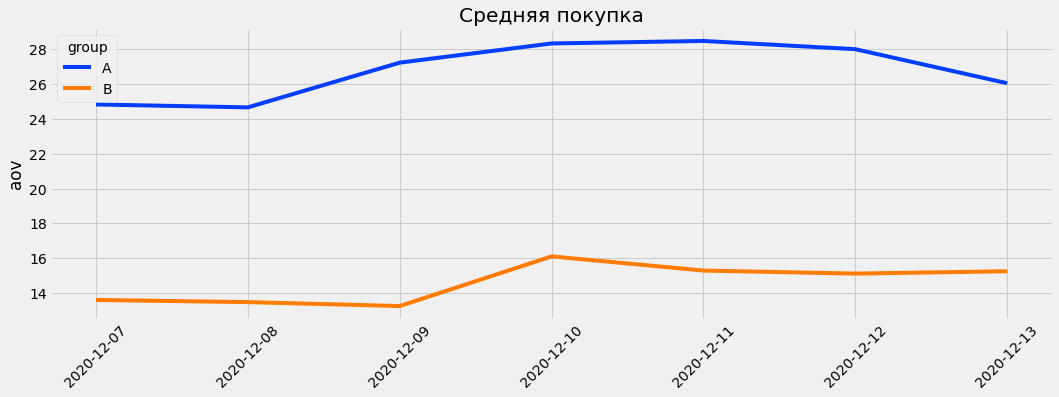

In [60]:
purchase_plot(work_df_3, 0)

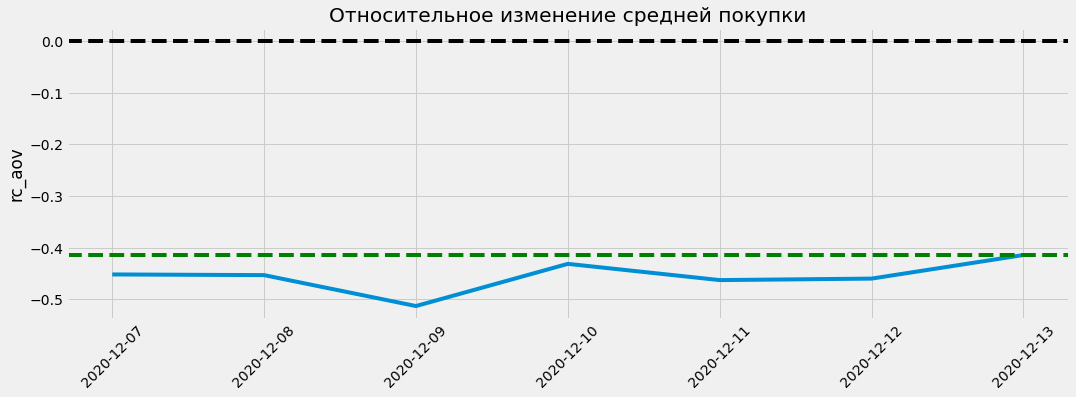

In [61]:
purchase_plot(work_df_3, 1)

Графики кумулятивной выручки, кумулятивной средней выручки и относительного изменения выручки, так же демонстрируют преобладание группы А над группой В.

## 5. Результаты эксперемента и проверка гипотез
[к оглавлению](#step_0)
<a class="anchor" id="step_5"></a>

Выдвинем гипотезы:
Все показатели конверсий не различаются между группами и все возможные отклонения случайны:

>- __H0__: Все показатели конверсий не различаются между группами и все возможные отклонения случайны;
>- __H1__: Все показатели конверсий не между группами различаются

Проверим, гипотезы 2 способами хи квадратом пропорций таблиц сопряженности и не парметрическим тестом Манна-Уитни. (Не парметрическим, т.к. данные в подобных случаях распределены не нормально). Создадим для этих целей функции

In [62]:
def chi_test(df, alpha=0.05):
    '''
    ФУНКЦИЯ ДЛЯ ВЫВОДА ОТЧЕТА О ПРОВЕРКЕ ГИПОТЕЗ ХИ КВАДРАТОМ
    На вход подаем:
    1. Сырой датафрейм и уровень альфа (по умолчанию 5%)
    2. Внутри создаем матрицу нулей и единиц где по столбцы это события
    строки это номера пользователей, на пресечении ноль - нет события, 1 - есть событие
    3. на основе этой матрицы рассчитываем таблица сопряженности и в цикле подаем на
    расчет p-value. Цикл это наши события
    4. После каждой итерации создаем в словаре строку (название события, p-value, комментарий по поводу принятия Н0 и относительное изменение метрики)
    5. Выводим отчет в виде датафрейма
    '''
    matrix = (df.pivot_table(index=['user_id', 'group'], 
                                  columns = 'event_name', 
                                  values='event_dt', 
                                  aggfunc='count').reset_index().
              drop(['user_id'], axis=1).fillna(False).
              set_index(keys='group').
              astype('bool').astype('int').reset_index())
    cols = matrix.columns[2:] # получаем имена событий
    alpha = alpha / len(cols) # скорректируем альфу по Бонферонни
    report = {} # ловарь заготовка ключи будут события - знаения список р-знач, альфа, что делани с Н0 и отклонение
    a = matrix.query('group == "A"')['login'].sum()
    b = matrix.query('group == "B"')['login'].sum()
    for i in cols:
        a_i = matrix.query('group == "A"')[i].sum()
        b_i = matrix.query('group == "B"')[i].sum()        
        chi_matrix = pd.crosstab(matrix['group'],matrix[i])
        p_value = st.chi2_contingency(chi_matrix[[0,1]], correction=False)[1]
        if p_value < alpha:
            solution = 'принимается'
        else:
            solution = 'отвергается'
        report[i] = [p_value, alpha, solution, (b_i/b) / (a_i/a) - 1]
    df_result = pd.DataFrame(report).T.reset_index()
    df_result.columns = ['событие', 
                         'p-значение', 
                         'альфа с поправкой', 
                         'Н0','изменение конверсии']  
    return df_result

In [63]:
def mw_test(df, alpha=0.05):
    '''
    ФУНКЦИЯ ДЛЯ ВЫВОДА ОТЧЕТА О ПРОВЕРКЕ ГИПОТЕЗ МАННОМ-УИТНИ
    На вход подаем:
    1. Сырой датафрейм и уровень альфа (по умолчанию 5%)
    2. Внутри создаем матрицу нулей и количества событий где по столбцы это события
    строки это номера пользователей, на пресечении ноль - нет события, цифра - есть событие и сколько их
    3. на основе этой матрицы рассчитываем таблица сопряженности и в цикле подаем на расчет p-value. Цикл это наши события
    4. После каждой итерации создаем в словаре строку (название события, p-value, 
    комментарий по поводу принятия Н0 и относительное изменение метрики)
    5. Выводим отчет в виде датафрейма
    '''
    matrix = (df.pivot_table(index=['user_id', 'group'], 
                             columns = 'event_name', 
                             values='event_dt', 
                             aggfunc='count').reset_index().
              drop(['user_id'], axis=1).fillna(False).
              set_index(keys='group').astype('int').reset_index())
    cols = matrix.columns[2:]
    alpha = alpha / len(cols)
    report = {}
    for i in cols:
        sampleA = matrix.query('group == "A"')[i]
        sampleB = matrix.query('group == "B"')[i]
        p_value = st.mannwhitneyu(sampleA, sampleB).pvalue
        diff = sampleB.mean()/sampleA.mean()-1
        if p_value < alpha:
            solution = 'принимается'
        else:
            solution = 'отвергается'
        report[i] = [p_value, alpha, solution, diff]
    df_result = pd.DataFrame(report).T.reset_index()
    df_result.columns = ['событие', 
                             'p-значение', 
                             'альфа с поправкой', 
                             'Н0','изменение конверсии']  
    return df_result
        

In [64]:
chi_test(work_df_3, alpha=0.05)

событие p-значение альфа с поправкой           Н0 изменение конверсии
0  product_cart      0.921             0.017  отвергается              -0.009
1  product_page      0.121             0.017  отвергается              -0.088
2      purchase      0.606             0.017  отвергается               0.068

In [65]:
mw_test(work_df_3, alpha=0.05)

событие p-значение альфа с поправкой           Н0 изменение конверсии
0  product_cart      0.497             0.017  отвергается               0.066
1  product_page      0.124             0.017  отвергается              -0.059
2      purchase      0.327             0.017  отвергается               0.074

Оба теста дают разные уровни р-значения, но все отвергают нулевую гипотезу. Между значениями конверсий есть статистически значимое различие. Причем не в лучшую сторону

Проверим как изменятся результаты, если удалить из данных выбросы

In [66]:
abnormalUsers = outlerz(work_df_3)

In [67]:
chi_test(work_df_3.query('user_id not in@abnormalUsers'), alpha=0.05)

событие p-значение альфа с поправкой           Н0 изменение конверсии
0  product_cart      0.789             0.017  отвергается              -0.030
1  product_page      0.136             0.017  отвергается              -0.085
2      purchase      0.895             0.017  отвергается               0.020

In [68]:
mw_test(work_df_3.query('user_id not in@abnormalUsers'), alpha=0.05)

событие p-значение альфа с поправкой           Н0 изменение конверсии
0  product_cart      0.410             0.017  отвергается               0.007
1  product_page      0.115             0.017  отвергается              -0.067
2      purchase      0.478             0.017  отвергается              -0.053

На очищенных данных результаты не особо изменились.

## 6. Выводы
[к оглавлению](#step_0)
<a class="anchor" id="step_6"></a>

Эксперимент показал что изменения в поведении участников контрольной и тестовой групп статистически различаются, но ожидаемого эффекта __за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%__ не достигают.

Делать выводы о рекомендации новой платежной воронки или наоборот - отказать во внедрении, преждевременно по следующим причинам:


>- Исторических данных нет,
>- Набор участников из Европы производился некорректно,
>- Проведение эксперимента на 5 дней пересеклось маркетинговыми мероприятиями связанными с Рождеством,
>- При проведении эксперимента спустя 1 неделю случился заметный перекос в наборе и действий участников,
>- Группы не равномерны по количеству участников,

Учитывая все перечисленные факторы результаты эксперимента следует признать __не показательным__